In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

plt.rc('figure', autolayout=True)
from numpy.random import seed

seed(10)
keras.utils.set_random_seed(10)
i=1
tf.__version__

2022-07-08 22:20:52.778172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 22:20:52.778191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/piranha/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


'2.8.0'

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [3]:
x_train = np.array(train_dataset['train_set_x'])
y_train = np.array(train_dataset['train_set_y'])
x_test = np.array(test_dataset['test_set_x'])
y_test = np.array(test_dataset['test_set_y'])

In [4]:
print(type(x_train))
print(x_train.shape)


<class 'numpy.ndarray'>
(1080, 64, 64, 3)


In [5]:
unique_labels = np.unique(y_train)
print(unique_labels,len(unique_labels))

[0 1 2 3 4 5] 6


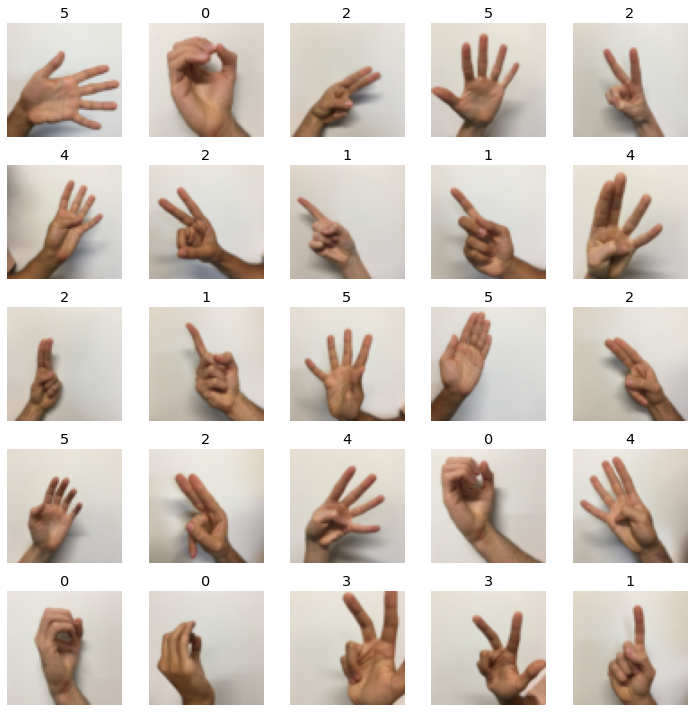

In [6]:

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")
i=0

In [7]:
x_train = x_train/255.0
x_test = x_test/255.0

In [8]:

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation = tf.nn.softmax)])


2022-07-08 22:20:55.714160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 22:20:55.714448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 22:20:55.714505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-08 22:20:55.714560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-08 22:20:55.714598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])


Epoch 1/200
34/34 [==============================] - 1s 13ms/step - loss: 2.7521 - accuracy: 0.1824 - val_loss: 1.8002 - val_accuracy: 0.2333
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 1.6842 - accuracy: 0.2898 - val_loss: 1.7814 - val_accuracy: 0.4167
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 1.5305 - accuracy: 0.3870 - val_loss: 1.6853 - val_accuracy: 0.2667
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 1.5052 - accuracy: 0.4046 - val_loss: 1.6438 - val_accuracy: 0.4083
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 1.5205 - accuracy: 0.3972 - val_loss: 1.3186 - val_accuracy: 0.4667
Epoch 6/200
34/34 [==============================] - 0s 10ms/step - loss: 1.3659 - accuracy: 0.4361 - val_loss: 1.3318 - val_accuracy: 0.4667
Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 1.1946 - accuracy: 0.5361 - val_loss: 1.2470 - val_accuracy: 0.5000
Epoch 8/2

[0.4929705262184143, 0.8500000238418579]

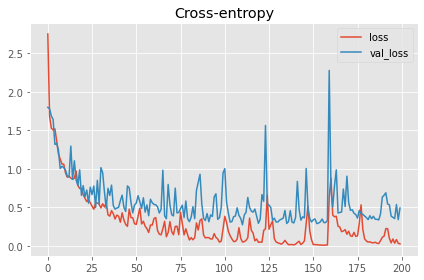

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=200
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
model.evaluate(x_test, y_test)


In [11]:
model.evaluate(x_test, y_test)


4/4 [==============================] - 0s 4ms/step - loss: 0.4930 - accuracy: 0.8500


[0.4929705262184143, 0.8500000238418579]

```
Epoch 200/200
34/34 [==============================] - 0s 11ms/step - loss: 0.0282 - accuracy: 0.9926 - val_loss: 0.4930 - val_accuracy: 0.8500
```

Tuning

In [12]:
def evaluate_model(model, X_test, y_test):
    """
    evaluate model on test set and show results in dataframe.
    
    Parameters
    ----------
    model : keras model
        trained keras model.
    X_test : numpy array
        Features of holdout set.
    y_test : numpy array
        Labels of holdout set.
        
    Returns
    -------
    display_df : DataFrame
        Pandas dataframe containing evaluation results.
    """
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

In [13]:

# Evaluate model on test set and add results to dataframe
results = evaluate_model(model, x_test, y_test)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

4/4 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.8500


,loss,accuracy
Baseline,0.492971,0.85


Epoch 1/200
34/34 [==============================] - 1s 21ms/step - loss: 3.3959 - accuracy: 0.1667 - val_loss: 1.9627 - val_accuracy: 0.2250
Epoch 2/200
34/34 [==============================] - 1s 17ms/step - loss: 2.0151 - accuracy: 0.2454 - val_loss: 1.8059 - val_accuracy: 0.2667
Epoch 3/200
34/34 [==============================] - 1s 17ms/step - loss: 1.7954 - accuracy: 0.3444 - val_loss: 1.8324 - val_accuracy: 0.2500
Epoch 4/200
34/34 [==============================] - 1s 17ms/step - loss: 1.7185 - accuracy: 0.3398 - val_loss: 1.7561 - val_accuracy: 0.4250
Epoch 5/200
34/34 [==============================] - 1s 17ms/step - loss: 1.7008 - accuracy: 0.3630 - val_loss: 1.6401 - val_accuracy: 0.2917
Epoch 6/200
34/34 [==============================] - 1s 18ms/step - loss: 1.4475 - accuracy: 0.4491 - val_loss: 1.4080 - val_accuracy: 0.4000
Epoch 7/200
34/34 [==============================] - 1s 17ms/step - loss: 1.2627 - accuracy: 0.5509 - val_loss: 1.2274 - val_accuracy: 0.5500
Epoch 

,loss,accuracy
Baseline,0.492971,0.85
L2 Regularization 0,0.318872,0.90


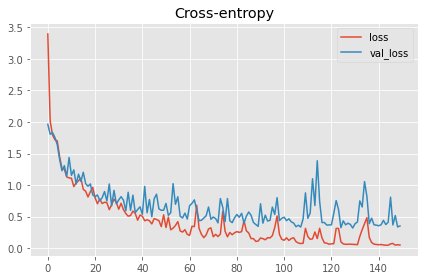

In [14]:
h_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(192,kernel_regularizer=tf.keras.regularizers.L2(1e-3),bias_regularizer=tf.keras.regularizers.L2(1e-3), activation = tf.nn.relu),
                                    tf.keras.layers.Dense(64,kernel_regularizer=tf.keras.regularizers.L2(1e-3),bias_regularizer=tf.keras.regularizers.L2(1e-3), activation = tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation = tf.nn.softmax)])
h_model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])



h_history = h_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=200,
    callbacks=[early_stopping]
)
h_history_df = pd.DataFrame(h_history.history)
h_history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
print(h_model.evaluate(x_test,y_test))
# Evaluate model on test set

tuned_df = evaluate_model(h_model, x_test, y_test)

# Set index to hypertuned
tuned_df.index = ["L2 Regularization "+str(i)]
i+=1
# Append results in dataframe
results = pd.concat([results,tuned_df],axis=0)
results

```
Epoch 130/200
34/34 [==============================] - 1s 22ms/step - loss: 0.0598 - accuracy: 0.9972 - val_loss: 0.3189 - val_accuracy: 0.9000
```

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 128)               1572992   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,590,278
Trainable params: 1,590,278
Non-trainable params: 0
_________________________________________________________________


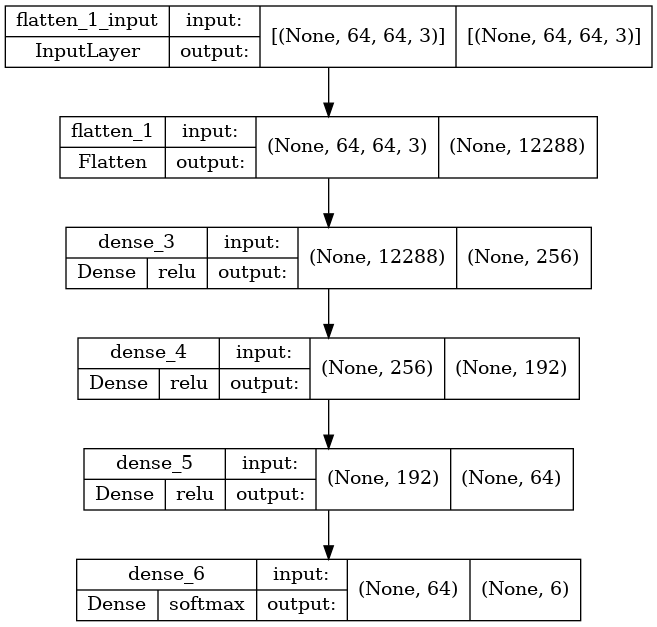

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(h_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,show_layer_activations=True)

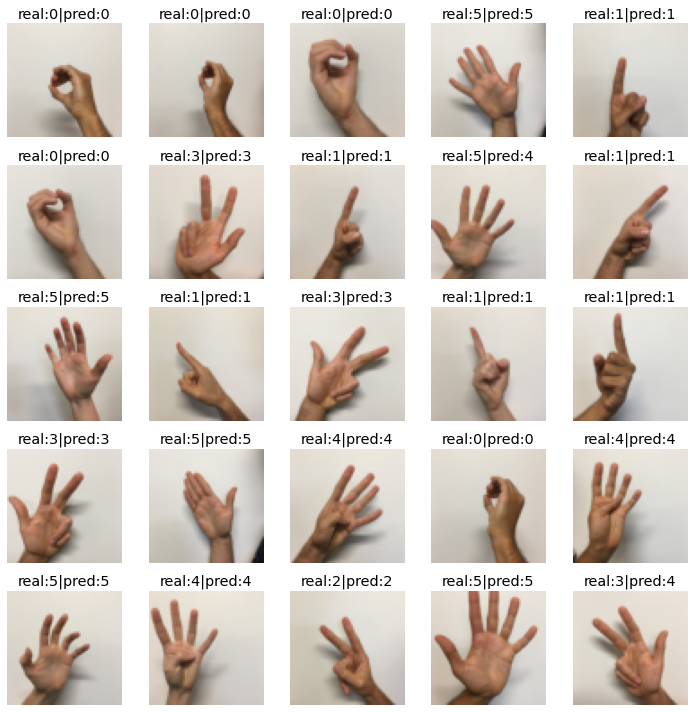

In [17]:
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i])
    k = np.argmax(h_model.predict(np.array([x_test[i]])),axis=-1)[0]
    plt.title('real:{}|pred:{}'.format(y_test[i],k))
    plt.axis("off")